In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emotions-dataset-for-nlp/val.txt
/kaggle/input/emotions-dataset-for-nlp/test.txt
/kaggle/input/emotions-dataset-for-nlp/train.txt


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from wordcloud import WordCloud
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.preprocessing import LabelEncoder


from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense,LSTM,Embedding,Bidirectional,Dropout

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from transformers import BertTokenizer,BertConfig,AdamW,BertForSequenceClassification,get_linear_schedule_with_warmup

In [3]:
train_data = pd.read_csv("../input/emotions-dataset-for-nlp/train.txt",header=None,sep=";",names=["comment","emotion"],encoding="utf-8")
test_data = pd.read_csv("../input/emotions-dataset-for-nlp/test.txt",header=None,sep=";",names=["comment","emotion"],encoding="utf-8")
validate_data = pd.read_csv("../input/emotions-dataset-for-nlp/val.txt",header=None,sep=";",names=["comment","emotion"],encoding="utf-8")

In [4]:
train_data.shape
test_data.shape
validate_data.shape

(2000, 2)

In [5]:
train_data.head()

,comment,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [6]:
train_data["length"] = [len(x) for x in train_data["comment"]]
train_data.head()

,comment,emotion,length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20


In [7]:
train_data[train_data["emotion"]=="sadness"]["length"].max()

299

In [8]:
train_data[train_data["emotion"]=="love"]

,comment,emotion,length
3,i am ever feeling nostalgic about the fireplac...,love,92
9,i feel romantic too,love,19
47,i can t let go of that sad feeling that i want...,love,93
61,i ate i could feel a gentle tingle throughout ...,love,117
68,i suppose my own truth needs to be shared i ha...,love,147
...,...,...,...
15936,im better than the rest of you feeling but a f...,love,70
15958,i feel there is going to be a sequel and i wou...,love,103
15963,i love what i do and i feel so blessed and luc...,love,145
15971,i feel it would not be loving of me not warn y...,love,97


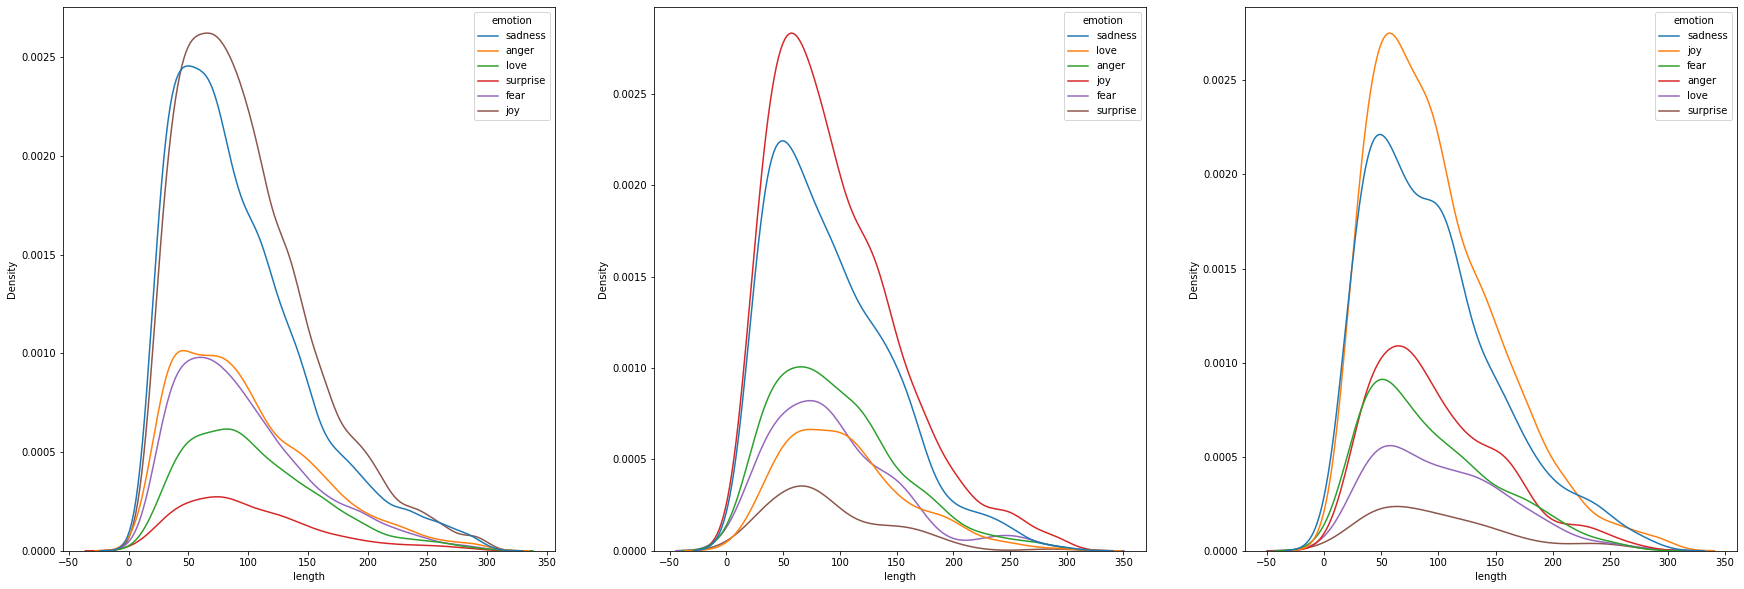

In [9]:
all_data = {"train data": train_data , "validation data": validate_data,"test data":test_data}
fig,ax = plt.subplots(1,3,figsize=(30,10))
for i,df in enumerate(all_data.values()):
    df2 = df.copy()
    df2["length"]=[len(x) for x in df2["comment"]]
    sns.kdeplot(data=df2,x="length",hue="emotion",ax=ax[i])
plt.show()

In [10]:
def words_cloud(wordcloud,df):
    plt.figure(figsize=(10,10))
    plt.title(df+" word cloud ",size=16)
    plt.imshow(wordcloud)
    plt.axis("off")

In [11]:
emotions_list = train_data["emotion"].unique()
emotions_list

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

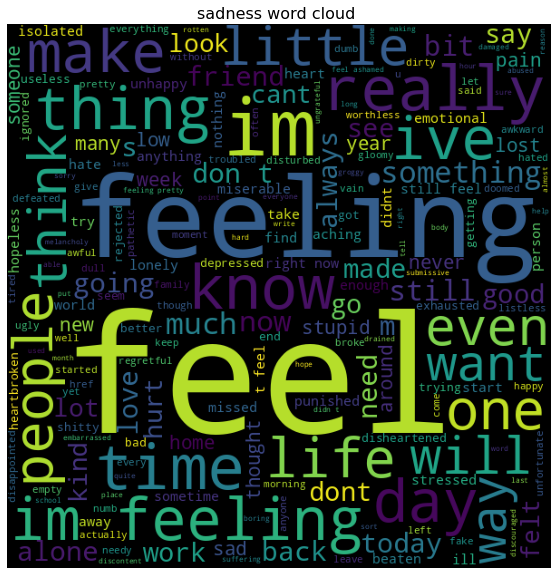

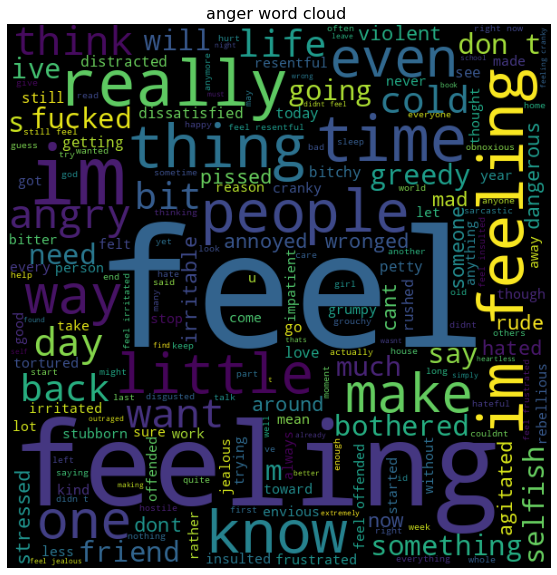

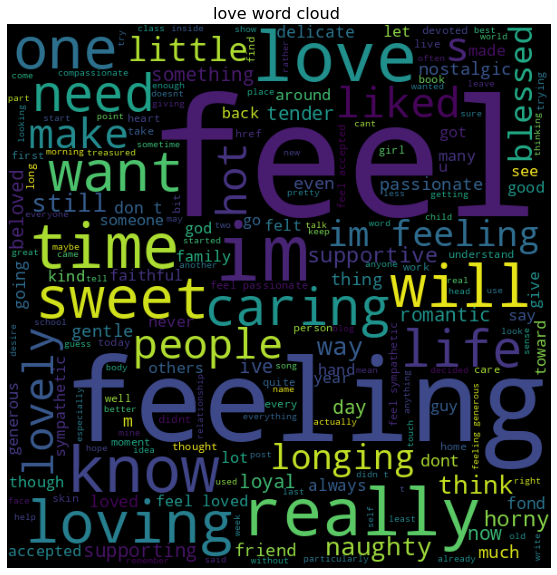

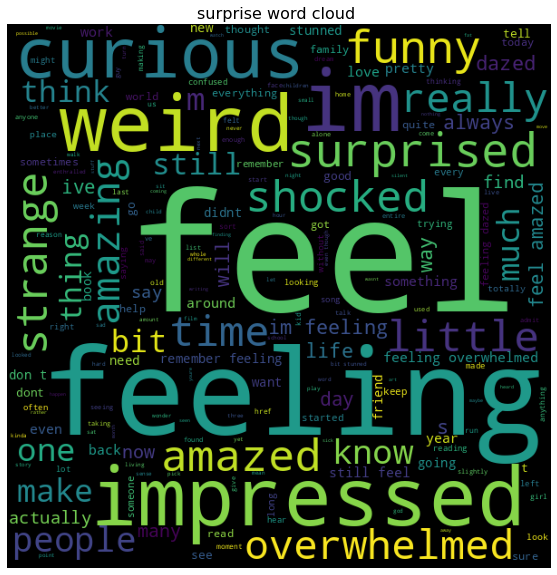

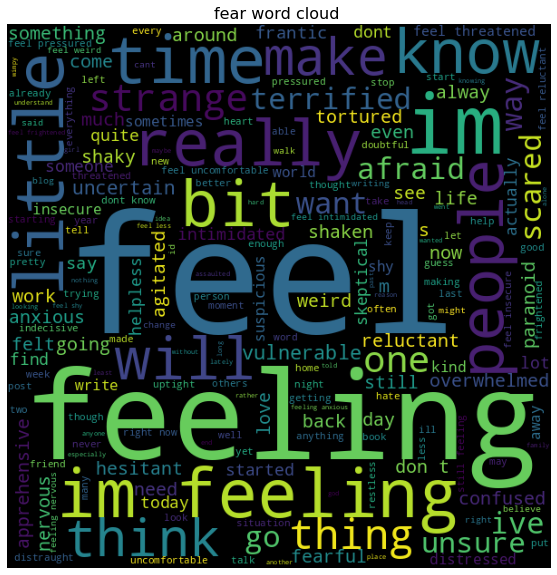

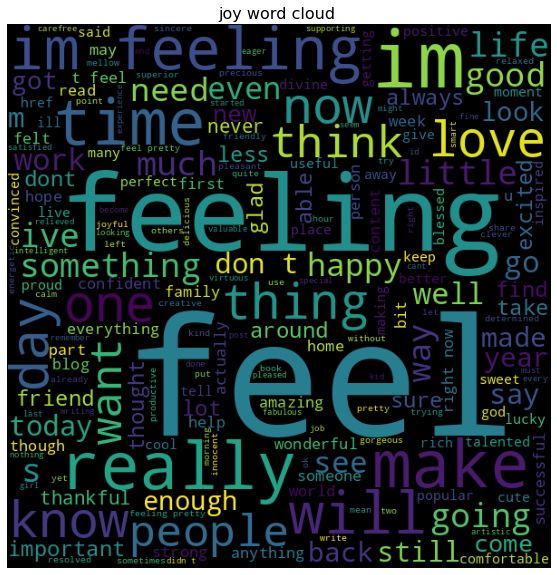

In [12]:
for emotion in emotions_list:
    text = '  '.join([sentence for sentence in train_data.loc[train_data["emotion"]==emotion,"comment"]])
    wordcloud = WordCloud(width=600,height=600).generate(text)
    
    words_cloud(wordcloud,emotion)

In [13]:
lb =LabelEncoder()
train_data["emotion"] = lb.fit_transform(train_data["emotion"])
test_data["emotion"] = lb.fit_transform(test_data["emotion"])
validate_data["emotion"] = lb.fit_transform(validate_data["emotion"])


In [14]:
train_data.head()

,comment,emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20


In [15]:
nltk.download("stopwords")
stopwords = set(nltk.corpus.stopwords.words("english"))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
max_len = train_data["length"].max()
max_len
vocabSize=11000

In [17]:
from tensorflow.keras.preprocessing.text import one_hot
def text_cleaning(df, column):
    """Removing unrelevent chars, Stemming and padding"""
    stemmer = PorterStemmer()
    corpus = []
    
    for text in df[column]:
        text = re.sub("[^a-zA-Z]", " ", text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=vocabSize) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word,maxlen=max_len,padding='pre')
    print(pad.shape)
    return pad

In [18]:
x_train = text_cleaning(train_data,"comment")
x_test = text_cleaning(test_data,"comment")
x_val = text_cleaning(validate_data,"comment")

(16000, 300)
(2000, 300)
(2000, 300)


In [19]:
y_train = train_data["emotion"]
y_test = test_data["emotion"]
y_val = validate_data["emotion"]

In [20]:

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [21]:
model = Sequential()
model.add(Embedding(input_dim=vocabSize,output_dim=150,input_length=300))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64,activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(6,activation='softmax'))

In [22]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 150)          1650000   
_________________________________________________________________
dropout (Dropout)            (None, 300, 150)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               142848    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 3

In [23]:
callback = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

In [24]:
x_train.shape

(16000, 300)

In [25]:
y_train.shape


(16000, 6)

In [26]:
hist = model.fit(x_train,y_train,epochs=10,batch_size=64,validation_data=(x_val,y_val),
                verbose=1, callbacks=[callback])

Epoch 1/10
250/250 [==============================] - 133s 523ms/step - loss: 1.5447 - accuracy: 0.3764 - val_loss: 1.1506 - val_accuracy: 0.5785
Epoch 2/10
250/250 [==============================] - 128s 514ms/step - loss: 0.7944 - accuracy: 0.7199 - val_loss: 0.5899 - val_accuracy: 0.8250
Epoch 3/10
250/250 [==============================] - 131s 523ms/step - loss: 0.4025 - accuracy: 0.8776 - val_loss: 0.4006 - val_accuracy: 0.8705
Epoch 4/10
250/250 [==============================] - 127s 507ms/step - loss: 0.2521 - accuracy: 0.9208 - val_loss: 0.3313 - val_accuracy: 0.8920
Epoch 5/10
250/250 [==============================] - 126s 505ms/step - loss: 0.1787 - accuracy: 0.9414 - val_loss: 0.3622 - val_accuracy: 0.8910
Epoch 6/10
250/250 [==============================] - 126s 503ms/step - loss: 0.1420 - accuracy: 0.9524 - val_loss: 0.3396 - val_accuracy: 0.8885
Epoch 7/10
250/250 [==============================] - 126s 505ms/step - loss: 0.1135 - accuracy: 0.9624 - val_loss: 0.3891 -

In [27]:
model.evaluate(x_val,y_val,verbose=1)

63/63 [==============================] - 7s 106ms/step - loss: 0.3313 - accuracy: 0.8920


[0.3312990069389343, 0.8920000195503235]

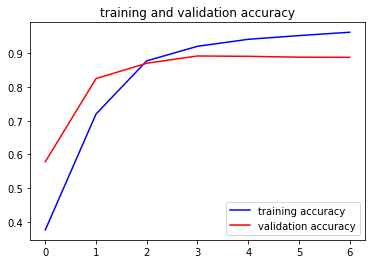

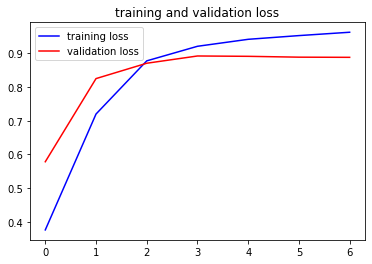

In [28]:
accuracy = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]
epochs = range(len(accuracy))

plt.plot(epochs,accuracy,"b",label="training accuracy")
plt.plot(epochs,val_acc,'r',label="validation accuracy")
plt.title("training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs,accuracy,"b",label="training loss")
plt.plot(epochs,val_acc,'r',label="validation loss")
plt.title("training and validation loss")
plt.legend()

plt.show()

In [29]:
def sentence_cleaning(sentence):
    stemmer = PorterStemmer()
    corpus = []
    text = re.sub("[^a-zA-Z]"," ",sentence)
    text = text.lower()
    text = text.split()
    
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    text = " ".join(text)
    corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=vocabSize) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word,maxlen=max_len,padding="pre")
    
    return pad

In [30]:
sentences = [
            "Don’t you dare tell lies to me?","For God’s sake, leave me alone!",
    "For f*ck’s sake!"
            ]

In [31]:
for sentence in sentences:
    print(sentence)

Don’t you dare tell lies to me?
For God’s sake, leave me alone!
For f*ck’s sake!


In [32]:

for sentence in sentences:
    print(sentence)
    sentence = sentence_cleaning(sentence)
    result = lb.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

Don’t you dare tell lies to me?
joy : 0.3290196359157562


For God’s sake, leave me alone!
sadness : 0.9775978922843933


For f*ck’s sake!
sadness : 0.5260806679725647




In [33]:
model.predict(sentence)

array([[0.03883234, 0.25720534, 0.163698  , 0.0024494 , 0.52608067,
        0.0117343 ]], dtype=float32)